# **SCTP Assoc AI/ML Developer: Log Data Classification**

# Notebook Init

In [40]:
import os
# print('KAGGLE_GCP_ZONE' in list(os.environ.keys()))
# print('COLAB_RELEASE_TAG' in list(os.environ.keys()))

RunningInKaggle = 'KAGGLE_GCP_ZONE' in list(os.environ.keys())
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
print(f"Kaggle: {RunningInKaggle}")
print(f"Colab: {RunningInCOLAB}")

Kaggle: False
Colab: True


In [41]:
import tensorflow as tf

def gpu_check():
    # check
    !nvidia-smi
    print(f"tensorflow version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    print(gpus)
    print(cpus)

def gpu_set(p_enable: bool=False):
    gpu_check()
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    try:
        if p_enable:
            tf.debugging.set_log_device_placement(True)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                # tf.config.set_visible_devices(gpus[0], 'GPU')
                tf.config.set_visible_devices(gpu, 'GPU')
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        else:
            tf.config.set_visible_devices(cpus[0], 'CPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# mount google drive in colab
def mount_gg_drive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def git_clone(p_url: str=None):
    !git clone https://github.com/NMustikha/SCTP-Capstone-4-Fraud-Detection

def find_files(p_dir: str = '/kaggle'):
    for dirname, _, filenames in os.walk(p_dir):
        for filename in filenames:
            print(os.path.join(dirname, filename))


In [42]:
from pathlib import Path
import tensorflow as tf

gpu_check()

# gpu_set(True)
# gpu_set(False)


/bin/bash: line 1: nvidia-smi: command not found
tensorflow version: 2.17.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [43]:
import os
import shutil
from pathlib import Path

LOG_TYPES = list() # to be updated from `tfidf.LABEL_ENCODER().fit_transform()`

if RunningInCOLAB:
    CWD = str(Path.cwd())
    # DATA_DIR = "../data" # local vs code setup
    DATA_DIR = "/content" # google colab
    HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
    MESSAGES_FILE = DATA_DIR+"/"+"messages"

    HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
    MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

    # filename for persisting the vectorizer and model
    TFIDF_FILE = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav'
    MODEL_FILE = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'

    mount_gg_drive()

elif RunningInKaggle:
    CWD = str(Path.cwd())
    DATA_DIR = CWD # kaggle
    HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
    MESSAGES_FILE = DATA_DIR+"/"+"messages"

    HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
    MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

    # filename for persisting the vectorizer and model
    TFIDF_FILE = CWD+'/'+'tfidf_vectorizer.sav'
    MODEL_FILE = CWD+'/'+'log_classifier_model.sav'

    BASE_DIR = '/kaggle'
    INPUT_DIR = BASE_DIR+'/input'

    print(f"BASE_DIR = {BASE_DIR}")
    print(f"CWD = {CWD}")
    print(f"INPUT_DIR = {INPUT_DIR}")

    print(f"\nFile listing in {BASE_DIR}")
    find_files(p_dir = BASE_DIR)
else:
    # running locally (PC/laptop)
    CWD = str(Path.cwd())
    # str(Path.cwd())
    DATA_DIR = CWD
    HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
    MESSAGES_FILE = DATA_DIR+"/"+"messages"

    HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
    MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

    # filename for persisting the vectorizer and model
    TFIDF_FILE = CWD+'/'+'tfidf_vectorizer.sav'
    MODEL_FILE = CWD+'/'+'log_classifier_model.sav'

def prn(variable):
    variable_name = [name for name, value in locals().items() if value is variable][0]
    if variable_name != 'variable': print(f"{variable_name} = [{variable}]")

    variable_name = [name for name, value in globals().items() if value is variable][0]
    if variable_name != 'variable': print(f"{variable_name} = [{variable}]")

prn(CWD)
prn(DATA_DIR)
prn(HTTP_ACCESS_LOG_FILE)
prn(MESSAGES_FILE)
prn(HTTP_ACCESS_LOG_CSV)
prn(MESSAGES_CSV)
prn(TFIDF_FILE)
prn(MODEL_FILE)


Mounted at /content/drive
CWD = [/content]
DATA_DIR = [/content]
HTTP_ACCESS_LOG_FILE = [/content/access_log]
MESSAGES_FILE = [/content/messages]
HTTP_ACCESS_LOG_CSV = [/content/access_log_final.csv]
MESSAGES_CSV = [/content/messages_final.csv]
TFIDF_FILE = [/content/drive/MyDrive/sctp-capstone-ml-log-data/model/tfidf_vectorizer.sav]
MODEL_FILE = [/content/drive/MyDrive/sctp-capstone-ml-log-data/model/log_classifier_model.sav]


In [44]:
# install python packages
%pip install -r /content/drive/MyDrive/sctp-capstone-ml-log-data/requirements.txt
# %pip install -r /kaggle/input/sctp-requirements/requirements.txt
# %pip install -r ./requirements.txt

In [45]:
# import libraries
import pandas
pandas.options.display.max_columns = None
pandas.set_option('display.max_columns', None)
pandas.option_context('mode.use_inf_as_na', True)

import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
from pprint import pprint as pp
import csv
import contractions
import string
import re
from unidecode import unidecode
import dateutil
from chardet import detect
import pickle
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Dataset

Dataset on log files are hosted at [Public Security Log Sharing Site](https://log-sharing.dreamhosters.com/), supported by [Dr. Anton A. Chuvakin](https://www.chuvakin.org/)

Bundle 1 log files is selected and accessible at [http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz](http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz)


The target log files for analysis are found in:
- `/var/log/httpd/access_log*`
- `/var/log/messages*`

These log files are:
- download the log file bundle
- untar the bundle
- respective log files are concatenated


In [46]:
# Download log bundle
# ```bash
# !curl -L http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz -o hnet-hon-var-log-02282006.tgz
# ```

import requests

url = 'http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz'
tgt_file = 'hnet-hon-var-log-02282006.tgz'
r = requests.get(url, allow_redirects=True)
with open(tgt_file, 'wb') as fin:
    fin.write(r.content)


In [47]:
# unwrap bundle tarball
# ```bash
# !tar -C ./ -xf hnet-hon-var-log-02282006.tgz
# ```

import os, sys, tarfile

tgt_file = 'hnet-hon-var-log-02282006.tgz'
DL_FILE = tgt_file

def extract(tar_url: str='test.tgz', extract_path='.'):
    print(f"tar_url = [{tar_url}]")
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])

try:
    extract(DL_FILE)
    print('Done.')
except Exception as e:
    print(e)


tar_url = [hnet-hon-var-log-02282006.tgz]
Done.


In [48]:
print(os.getcwd())
print(CWD)
print(DATA_DIR)

/content
/content
/content


In [49]:
# combine log files for respective var/log/messages* and var/log/httpd/access_log* files
# ```bash
# !rm ./access_log
# !rm ./messages
# !ls ./var/log/httpd/ | grep access_log | xargs -I {} cat "./var/log/httpd/{}" >> ./access_log
# !ls ./var/log/ | grep messages | xargs -I {} cat "./var/log/{}" >> ./messages
# !wc -l /content/access_log
# !wc -l /content/messages
# ```

import os
import glob
import pathlib


# for root, dirs, files in os.walk("/mydir",):
def combine_files(p_dir: str = './var/log', p_startswith: str = 'messages'):
    _CWD = os.getcwd()
    # _CWD = DATA_DIR
    os.chdir(p_dir)
    filenames = []
    # get all filenames
    for file in glob.glob(p_startswith+'*'):
        # print(file)
        filenames.append(file)

    total_line_cnt = 0
    try:
        # concatenate files
        tgt_file = _CWD+'/'+p_startswith
        with open(tgt_file, 'wb') as outfile:
            for fname in filenames:
                with open(fname, 'rb') as infile:
                    outfile.write(infile.read())
        os.chdir(_CWD)
        with open(tgt_file, 'r', errors='ignore') as f:
            cnt = len(f.readlines())
            print(f"{tgt_file} line count: {cnt}")

    except Exception as e:
        print(e)
        os.chdir(_CWD)


os.chdir(DATA_DIR)
pathlib.Path('./messages').unlink(missing_ok=True)
pathlib.Path('./access_log').unlink(missing_ok=True)
os.listdir('./')

combine_files(p_dir = './var/log', p_startswith = 'messages')
os.chdir(DATA_DIR)

combine_files(p_dir = './var/log/httpd', p_startswith = 'access_log')
os.chdir(DATA_DIR)

print('Done')


/content/messages line count: 25567
/content/access_log line count: 36310
Done


In [50]:
# !cp ./access_log ./messages /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/

# cleanup
# !rm -rf ./hnet-hon-var-log-02282006.tgz ./var

# Load, Clean and Convert to CSV File

Main steps:
1. Remove non-ascii characters from log files
2. Convert log file to csv structure


In [51]:
from chardet import detect
def has_non_ascii(p_file: str = None):
    cnt = 0
    encoding = lambda x: detect(x)['encoding']
    # with open(tgt_file+".txt", 'a', encoding='utf-a') as fout:
    with open(tgt_file, 'rb') as f:
        for i in f.readlines():
            cnt += 1
            if encoding(i) != 'ascii':
                # print(f"line {cnt} ... contains non-ascii characters.")
                print(f"File {p_file} has non-ascii characters ... line [{cnt}] onwards.")

            # exit when first detected non-ascii line
            if cnt>0: return True
            else: return False


def scrub_non_ascii(p_file: str = None):
    cnt = 0
    encoding = lambda x: detect(x)['encoding']

    tgt_file = p_file
    cnt = 0
    line_nums = []
    # detect lines with non-ascii characters
    # https://www.w3schools.com/charsets/ref_html_8859.asp
    with open(tgt_file, 'rb') as fin:
        for i in fin.readlines():
            cnt += 1
            if encoding(i) != 'ascii':
                # print(f"line {cnt} ... contains {encoding(i)} characters ... ignored")
                line_nums.append(cnt)
            # else:
            #     print(f"line {cnt} ... contains {encoding(i)} characters")


    print(f"Lines with non-ascii characters:\n{line_nums}")
    cnt = 0
    with open(tgt_file, 'r', encoding='utf-8', errors='ignore') as fin:
        with open(tgt_file+".txt", 'w', encoding='utf-8') as fout:
            for i in fin.readlines():
                cnt += 1
                if cnt in line_nums:
                    print(f"line {cnt} ... skipped due to presence of non-ascii character.")
                else:
                    fout.write(i)
    print(f"New file written to [{tgt_file}.txt]")
    return f"{tgt_file}.txt"

def clean_str(p_str: str=None):

    str_lower = lambda x: str(x).lower() # lower casing
    str_exp_contraction = lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]) # expand contractions
    # str_rm_punct = lambda x: re.sub('[%s]' % re.escape(string.punctuation.replace('/', '').replace('@','')), ' ' , x) # remove punctuations except '/' and '@'
    str_rm_punct = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x) # remove punctuations
    str_rm_spaces = lambda x: re.sub(' +', ' ', x) # remove double spaces
    str_rpl_diacritics = lambda x: unidecode(x, errors="preserve") # replace Diacritics with nearest characters.
    str_rm_chr = lambda x: ' '.join([ i for i in x.split() if len(i)>2 ]) # remove 1 and 2 characters string

    p_str = str_lower(p_str)
    p_str = str_exp_contraction(p_str)
    p_str = str_rm_punct(p_str)
    p_str = str_rm_spaces(p_str)
    p_str = str_rpl_diacritics(p_str)
    p_str = str_rm_chr(p_str)
    return p_str

def clean_logs(p_entry: pandas.Series=None):
    p_entry = pandas.Series(p_entry).apply(clean_str)
    return p_entry

# def save_model(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
def save_obj(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
    # save the model to disk
    filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
    # pickle.dump(best_model, open(filename, 'wb'))
    pickle.dump(p_obj, open(p_filename, 'wb'))

# def load_model(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
def load_obj(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
    # load the model from disk
    # filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
    return pickle.load(open(p_filename, 'rb'))


## httpd `access_log`

### Convert to csv format

In [52]:
tgt_file = HTTP_ACCESS_LOG_FILE

In [53]:
import csv

def httpd_access_log_to_csv(p_file: str = None) -> list:
    logs = list()
    cnt = 0
    tgt_file = p_file
    if has_non_ascii(tgt_file):
        tgt_file = scrub_non_ascii(tgt_file)

    with open(tgt_file, 'r') as f:
        for i in f.readlines():
            cnt += 1
            # print(cnt)
            j = (i
                .replace('- [', '- @@')
                .replace('] "', '@@ "')
            )
            k = [ m.strip() for m in j.split('@@')]
            k[0] = k[0].replace(' - -', '')
            k[1] = k[1].replace(' -0500', '')
            k[1] = k[1].replace(' -0400', '')
            # k[2] = (k[2]
            #         .replace('"', '][')
            #         )        # print(k)
            # k[2] = k[2][1:-1]
            k[2] = i # keep the entire log entry training
            k.append('httpd_access_log')
            logs.append(k)
    return logs


logs = httpd_access_log_to_csv(tgt_file)
fields = ['ipaddress','datetime','content','log_type']
# pp(logs[:3])
with open(tgt_file+'.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(logs)

pp(logs[:2])


Lines with non-ascii characters:
[]
New file written to [/content/access_log.txt]
[['24.65.111.203',
  '28/Aug/2005:05:07:44',
  '24.65.111.203 - - [28/Aug/2005:05:07:44 -0400] "GET / HTTP/1.1" 403 3931 '
  '"-" "Mozilla/4.0 (compatible; MSIE 5.5; Windows 98)"\n',
  'httpd_access_log'],
 ['66.161.178.137',
  '28/Aug/2005:06:22:08',
  '66.161.178.137 - - [28/Aug/2005:06:22:08 -0400] "GET / HTTP/1.1" 403 3931 '
  '"-" "Mozilla/4.0 (compatible; MSIE 5.5; Windows 98)"\n',
  'httpd_access_log']]


### Feature Extraction

In [54]:
tgt_file = HTTP_ACCESS_LOG_FILE+'.csv'

df = pd.read_csv(tgt_file)
display(df.head())
display(df['content'].head())
# print(f"[{df[:2]['datetime'].str.lower()}]")
# df['date'] = df['datetime'].str[:11]
# df['time'] = df['datetime'].str[12:]
df['datetime'] = df['datetime'].str.replace(":"," ", 1)
df['datetime'] = pd.to_datetime(df['datetime'],dayfirst=True)
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
# df['day_of_week'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df.drop('ipaddress', inplace=True, axis=1)

df.info()
display(df.head())

df['content'] = clean_logs(df['content'])
# display(df['content'].head())
display(df.head())

# df = df[df['content'].notnull()]
# display(df[df['content'].isnull()])

tgt_file = HTTP_ACCESS_LOG_FILE+'_final.csv'
df.to_csv(tgt_file,index=False)


,ipaddress,datetime,content,log_type
0,24.65.111.203,28/Aug/2005:05:07:44,24.65.111.203 - - [28/Aug/2005:05:07:44 -0400]...,httpd_access_log
1,66.161.178.137,28/Aug/2005:06:22:08,66.161.178.137 - - [28/Aug/2005:06:22:08 -0400...,httpd_access_log
2,61.178.57.62,28/Aug/2005:06:59:48,61.178.57.62 - - [28/Aug/2005:06:59:48 -0400] ...,httpd_access_log
3,61.180.95.174,28/Aug/2005:07:35:57,61.180.95.174 - - [28/Aug/2005:07:35:57 -0400]...,httpd_access_log
4,61.10.7.243,28/Aug/2005:08:25:59,"61.10.7.243 - - [28/Aug/2005:08:25:59 -0400] ""...",httpd_access_log


,content
0,24.65.111.203 - - [28/Aug/2005:05:07:44 -0400]...
1,66.161.178.137 - - [28/Aug/2005:06:22:08 -0400...
2,61.178.57.62 - - [28/Aug/2005:06:59:48 -0400] ...
3,61.180.95.174 - - [28/Aug/2005:07:35:57 -0400]...
4,"61.10.7.243 - - [28/Aug/2005:08:25:59 -0400] ""..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36310 entries, 0 to 36309
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  36310 non-null  datetime64[ns]
 1   content   36310 non-null  object        
 2   log_type  36310 non-null  object        
 3   day       36310 non-null  int32         
 4   month     36310 non-null  int32         
 5   year      36310 non-null  int32         
 6   hour      36310 non-null  int32         
 7   minute    36310 non-null  int32         
 8   second    36310 non-null  int32         
dtypes: datetime64[ns](1), int32(6), object(2)
memory usage: 1.7+ MB


,datetime,content,log_type,day,month,year,hour,minute,second
0,2005-08-28 05:07:44,24.65.111.203 - - [28/Aug/2005:05:07:44 -0400]...,httpd_access_log,28,8,2005,5,7,44
1,2005-08-28 06:22:08,66.161.178.137 - - [28/Aug/2005:06:22:08 -0400...,httpd_access_log,28,8,2005,6,22,8
2,2005-08-28 06:59:48,61.178.57.62 - - [28/Aug/2005:06:59:48 -0400] ...,httpd_access_log,28,8,2005,6,59,48
3,2005-08-28 07:35:57,61.180.95.174 - - [28/Aug/2005:07:35:57 -0400]...,httpd_access_log,28,8,2005,7,35,57
4,2005-08-28 08:25:59,"61.10.7.243 - - [28/Aug/2005:08:25:59 -0400] ""...",httpd_access_log,28,8,2005,8,25,59


,datetime,content,log_type,day,month,year,hour,minute,second
0,2005-08-28 05:07:44,111 203 aug 2005 0400 get http 403 3931 mozill...,httpd_access_log,28,8,2005,5,7,44
1,2005-08-28 06:22:08,161 178 137 aug 2005 0400 get http 403 3931 mo...,httpd_access_log,28,8,2005,6,22,8
2,2005-08-28 06:59:48,178 aug 2005 0400 get http 403 3931 mozilla co...,httpd_access_log,28,8,2005,6,59,48
3,2005-08-28 07:35:57,180 174 aug 2005 0400 get http 403 3931 mozill...,httpd_access_log,28,8,2005,7,35,57
4,2005-08-28 08:25:59,243 aug 2005 0400 get http 403 3931 mozilla co...,httpd_access_log,28,8,2005,8,25,59


## `messages` log

### Convert to csv format


In [55]:
tgt_file = MESSAGES_FILE

def sys_msg_to_csv(p_file: str = None) -> list:
    msg = list()
    cnt = 0
    tgt_file = p_file
    if has_non_ascii(tgt_file):
        tgt_file = scrub_non_ascii(tgt_file)

    with open(tgt_file, 'r', encoding='utf-8') as f:
        for i in f.readlines():
            cnt += 1
            # print(cnt)
            j = (i
                .replace(' combo ', '@@')
            )
            k = [ m.strip() for m in j.split('@@')]

            k[1] = k[1].replace(':', '@@', 1)
            tmp = k[1].split('@@')
            # print(f"{len(tmp)} {tmp}")
            k[1] = tmp[0].strip()
            if len(tmp)>1:
                # k.append(tmp[1].strip())
                k.append(i) # keep the entire log entry for training
            else:
                k.append([''])
            k.append('system_messages')
            msg.append(k)

    # ic(msg)
    return msg


msg = sys_msg_to_csv(tgt_file)

fields = ['datetime','component','content','log_type']
with open(tgt_file+'.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(msg)

Lines with non-ascii characters:
[12311, 12994, 13469, 13470, 21125, 21126, 21127, 21128, 21129, 23892, 23893, 24731, 24732, 24733, 24975, 24976, 24977, 24978, 24979, 24980]
line 12311 ... skipped due to presence of non-ascii character.
line 12994 ... skipped due to presence of non-ascii character.
line 13469 ... skipped due to presence of non-ascii character.
line 13470 ... skipped due to presence of non-ascii character.
line 21125 ... skipped due to presence of non-ascii character.
line 21126 ... skipped due to presence of non-ascii character.
line 21127 ... skipped due to presence of non-ascii character.
line 21128 ... skipped due to presence of non-ascii character.
line 21129 ... skipped due to presence of non-ascii character.
line 23892 ... skipped due to presence of non-ascii character.
line 23893 ... skipped due to presence of non-ascii character.
line 24731 ... skipped due to presence of non-ascii character.
line 24732 ... skipped due to presence of non-ascii character.
line 24

### Feature Extraction

In [56]:
tgt_file = MESSAGES_FILE+'.csv'

import dateutil.utils

df = pd.read_csv(tgt_file)
display(df.head())

# df['datetime'] = [ i.split() for i in df['datetime'].str.replace(":"," ", 1) ]

df['datetime'] = [ i.split() for i in df['datetime'] ]
df['datetime'] = [ ' '.join([i[1],i[0],'2017',i[2]]) for i in df['datetime'] ]
# df['datetime'] = [ ' '.join([' '.join([i[2],i[0],'20'+i[1]]),':'.join([i[3],'00'])]) for i in df['datetime'] ]
# display(df.head())

df['datetime'] = pd.to_datetime(df['datetime'],dayfirst=True)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['content'] = df['component'] + ' ' + df['content']
df.drop('component', inplace=True, axis=1)
df = df[df['content'].notnull()]

df['content'] = clean_logs(df['content'])
display(df.head())

df.to_csv(MESSAGES_FILE+'_final.csv',index=False)


,datetime,component,content,log_type
0,Nov 20 04:09:36,syslogd 1.4.1,Nov 20 04:09:36 combo syslogd 1.4.1: restart.\n,system_messages
1,Nov 20 04:09:37,logrotate,Nov 20 04:09:37 combo logrotate: ALERT exited ...,system_messages
2,Nov 20 05:05:27,kernel,Nov 20 05:05:27 combo kernel: Out of Memory: K...,system_messages
3,Nov 20 05:10:25,kernel,Nov 20 05:10:25 combo kernel: Out of Memory: K...,system_messages
4,Nov 20 05:10:39,kernel,Nov 20 05:10:39 combo kernel: Out of Memory: K...,system_messages


,datetime,content,log_type,year,month,day,hour,minute,second
0,2017-11-20 04:09:36,syslogd nov combo syslogd restart,system_messages,2017,11,20,4,9,36
1,2017-11-20 04:09:37,logrotate nov combo logrotate alert exited abn...,system_messages,2017,11,20,4,9,37
2,2017-11-20 05:05:27,kernel nov combo kernel out memory killed proc...,system_messages,2017,11,20,5,5,27
3,2017-11-20 05:10:25,kernel nov combo kernel out memory killed proc...,system_messages,2017,11,20,5,10,25
4,2017-11-20 05:10:39,kernel nov combo kernel out memory killed proc...,system_messages,2017,11,20,5,10,39


## Consolidate into 1 Dataset

In [57]:
# further consolidate the column data

tgt_file = HTTP_ACCESS_LOG_CSV
df_httpd = pd.read_csv(tgt_file)
# df_httpd.drop('ipaddress', axis=1, inplace=True)
# display(df_httpd.head())
# display(df_httpd.info())

tgt_file = MESSAGES_CSV
df_msg = pd.read_csv(tgt_file)
# df_msg['content'] = df_msg['component'] + ' ' + df_msg['content']
# df_msg.drop('component', axis=1, inplace=True)
# df_msg.info()

display(df_msg[df_msg['content'].isnull()])
df_msg = df_msg[df_msg['content'].notnull()]
display(df_msg[df_msg['content'].isnull()])

df = pandas.concat([df_httpd,df_msg],ignore_index=True)
# shuffle to ensure dataset is "mixed well"
df = df.sample(frac=1).reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.to_csv(DATA_DIR+'/'+'combined_log.csv',index=False)

# if RunningInCOLAB:
#     source = DATA_DIR+'/'+'combined_log.csv'
#     destination = DATA_DIR+'/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv'
#     dest = shutil.copyfile(source, destination)
#     # !cp {DATA_DIR+'/'+'combined_log.csv'} /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv
# elif RunningInKaggle:
#     source = DATA_DIR+'/'+'combined_log.csv'
#     destination = DATA_DIR+'/dataset.csv'
#     dest = shutil.copyfile(source, destination)
# else:
#     source = DATA_DIR+'/'+'combined_log.csv'
#     destination = DATA_DIR+'/dataset.csv'
#     dest = shutil.copyfile(source, destination)

if RunningInCOLAB: destination = DATA_DIR+'/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv'
else: destination = DATA_DIR+'/dataset.csv'

DATASET_CSV = destination

source = DATA_DIR+'/'+'combined_log.csv'
dest = shutil.copyfile(source, CWD+'/'+'dataset.csv')
print(dest)

dest = shutil.copyfile(source, DATASET_CSV)
print(dest)


,datetime,content,log_type,year,month,day,hour,minute,second


,datetime,content,log_type,year,month,day,hour,minute,second


/content/dataset.csv
/content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv


In [58]:
print("Check for rows with nulls")
print(df.isnull().sum())

# display(df[df['content'].notnull()])
# display(df[df['content'].notnull()])

# display(df[df['log_type']=='httpd_access_log'].head())
# display(df[df['log_type']=='system_messages'].head())
df.info()
display(df.sample(5))

Check for rows with nulls
datetime    0
content     0
log_type    0
day         0
month       0
year        0
hour        0
minute      0
second      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61857 entries, 0 to 61856
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  61857 non-null  datetime64[ns]
 1   content   61857 non-null  object        
 2   log_type  61857 non-null  object        
 3   day       61857 non-null  int64         
 4   month     61857 non-null  int64         
 5   year      61857 non-null  int64         
 6   hour      61857 non-null  int64         
 7   minute    61857 non-null  int64         
 8   second    61857 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 4.2+ MB


,datetime,content,log_type,day,month,year,hour,minute,second
12285,2017-11-21 08:50:20,kernel nov combo kernel out memory killed proc...,system_messages,21,11,2017,8,50,20
51227,2017-02-22 01:55:44,ftpd 5774 feb combo ftpd 5774 connection from ...,system_messages,22,2,2017,1,55,44
4562,2006-01-21 19:21:00,225 203 226 jan 2006 0500 post blog xmlrpc php...,httpd_access_log,21,1,2006,19,21,0
60466,2006-01-15 02:35:53,210 245 188 jan 2006 0500 post blog xmlrpc php...,httpd_access_log,15,1,2006,2,35,53
25952,2006-02-17 23:31:48,214 feb 2006 0500 post blogs xmlsrv xmlrpc php...,httpd_access_log,17,2,2006,23,31,48


***
# Exploratory Data Analysis

## Load `dataset.csv`

In [59]:
# !cp /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv /content/dataset.csv

In [60]:
# if RunningInCOLAB: DATASET_CSV = DATA_DIR+'/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv'
# else: DATASET_CSV = DATA_DIR+'/dataset.csv'

# Load from dataset.csv
DATASET_CSV = DATA_DIR+'/dataset.csv'

# load from the combined dataset.csv
tgt_file = DATASET_CSV
df = pd.read_csv(tgt_file)

## TODO: create vocabulary

In [61]:
# word length of 'content' column
# df['log_length'] = df['content'].apply(lambda x: len(str(x).split()))
df['datetime'] = pd.to_datetime(df['datetime'],yearfirst=True)

print(df.info())
print(df.head())
display(df.describe(percentiles=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9]))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61857 entries, 0 to 61856
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  61857 non-null  datetime64[ns]
 1   content   61857 non-null  object        
 2   log_type  61857 non-null  object        
 3   day       61857 non-null  int64         
 4   month     61857 non-null  int64         
 5   year      61857 non-null  int64         
 6   hour      61857 non-null  int64         
 7   minute    61857 non-null  int64         
 8   second    61857 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 4.2+ MB
None
             datetime                                            content  \
0 2017-01-31 04:35:49  sshd pam unix 3669 jan combo sshd pam unix 366...   
1 2005-06-17 16:20:46            238 240 jun 2005 0400 get http 403 3931   
2 2005-12-01 18:28:01  dec 2005 0500 get cgi bin awstats configdir ec...   
3 2006-0

,datetime,day,month,year,hour,minute,second
count,61857,61857.000000,61857.000000,61857.000000,61857.000000,61857.000000,61857.000000
mean,2010-10-17 13:32:12.423476736,16.705967,6.402105,2010.298867,10.502158,28.398645,29.988829
min,2005-06-09 07:11:21,1.000000,1.000000,2005.000000,0.000000,0.000000,0.000000
10%,2005-09-04 18:28:13,5.000000,1.000000,2005.000000,2.000000,5.000000,6.000000
20%,2005-11-19 19:18:27,9.000000,1.000000,2005.000000,4.000000,10.000000,12.000000
30%,2006-01-14 12:24:01,11.000000,2.000000,2006.000000,5.000000,17.000000,18.000000
50%,2006-02-15 16:51:54,17.000000,7.000000,2006.000000,10.000000,29.000000,30.000000
70%,2017-08-02 07:40:42,22.000000,11.000000,2017.000000,15.000000,40.000000,42.000000
90%,2017-11-28 23:35:19.200000,28.000000,11.000000,2017.000000,20.000000,52.000000,53.000000
max,2017-12-31 04:07:34,31.000000,12.000000,2017.000000,23.000000,59.000000,59.000000


Length of top 20 longest log entry:
[8159, 7301, 7300, 7299, 7299, 7085, 6956, 6955, 6954, 6378, 6226, 6226, 6226, 6226, 6226, 6226, 6226, 6226, 6226, 6226]
Top 20 frequency:
[11667, 5699, 5600, 5528, 5314, 3368, 3186, 2400, 1972, 1921, 1035, 1024, 1020, 996, 901, 884, 791, 778, 685, 650]


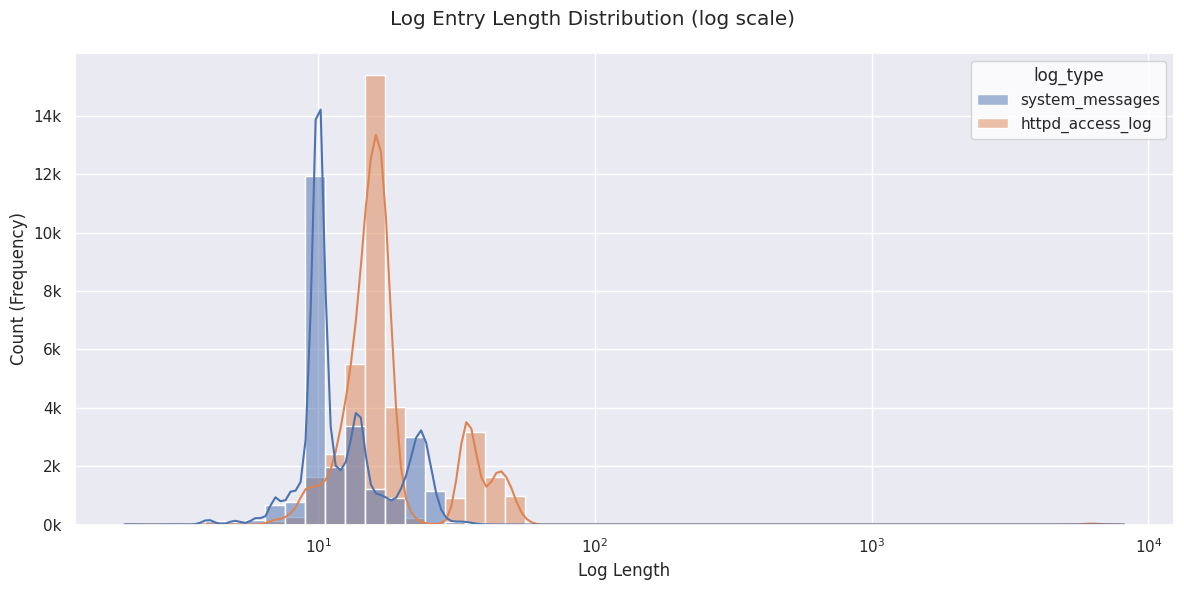

In [62]:
import seaborn as sns

# EDA - word count

def eda_word_count(p_df: pandas.DataFrame=None,
                   p_col_content:str='content',
                   p_col_hue:str='log_type') -> None:
    df_content = p_df[p_col_content]
    p_df['log_length'] = df_content.apply(lambda x: len(str(x).split()))

    print(f"Length of top 20 longest log entry:\n{sorted(df['log_length'], reverse=True)[:20]}")

    common_occurrence = Counter(p_df['log_length'])
    print(f"Top 20 frequency:\n{sorted(list(common_occurrence.values()), reverse=True)[:20]}")

    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    fig.suptitle('Log Entry Length Distribution (log scale)')

    # sns.set_theme(style="darkgrid")
    sns.set_theme(style='ticks')
    # set log scale for better visibility to distribution
    # sns.histplot(data=p_df, x='log_length', hue='log_type',bins=50)
    sns.histplot(data=p_df, x='log_length', hue='log_type',bins=50, log_scale=True, kde=True )

    x_limit = (int(sorted(df['log_length'], reverse=True)[0]/1000)*1000)+1000
    y_limit = (int(sorted(list(common_occurrence.values()), reverse=True)[0]/1000)*1000)+1000*4

    # xticks = np.arange(0,x_limit,1000)
    # xlabels = [f'{x // 1000}k' for x in xticks]
    # ax.set_xticks(xticks)
    # ax.set_xticklabels(xlabels)

    yticks = np.arange(0,y_limit,1000*2)
    ylabels = [f'{x // 1000}k' for x in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Count (Frequency)')

    ax.set_xlabel('Log Length')
    fig.tight_layout()

eda_word_count(df, p_col_content='content', p_col_hue='log_type')


Top 25 word count:
[196657, 39512, 36550, 30752, 30649, 30645, 30515, 28709, 28061, 27562, 25529, 22039, 21713, 21596, 19133, 18964, 17699, 16646, 16144, 14177, 12266, 11963, 11482, 10689, 10501]
Next top 25 word count:
[10491, 10452, 10404, 10052, 9113, 9043, 8249, 6949, 6838, 6624, 6073, 5375, 5375, 5254, 5213, 5180, 5053, 4899, 4873, 4614, 4302, 4232, 4092, 4092, 4092]


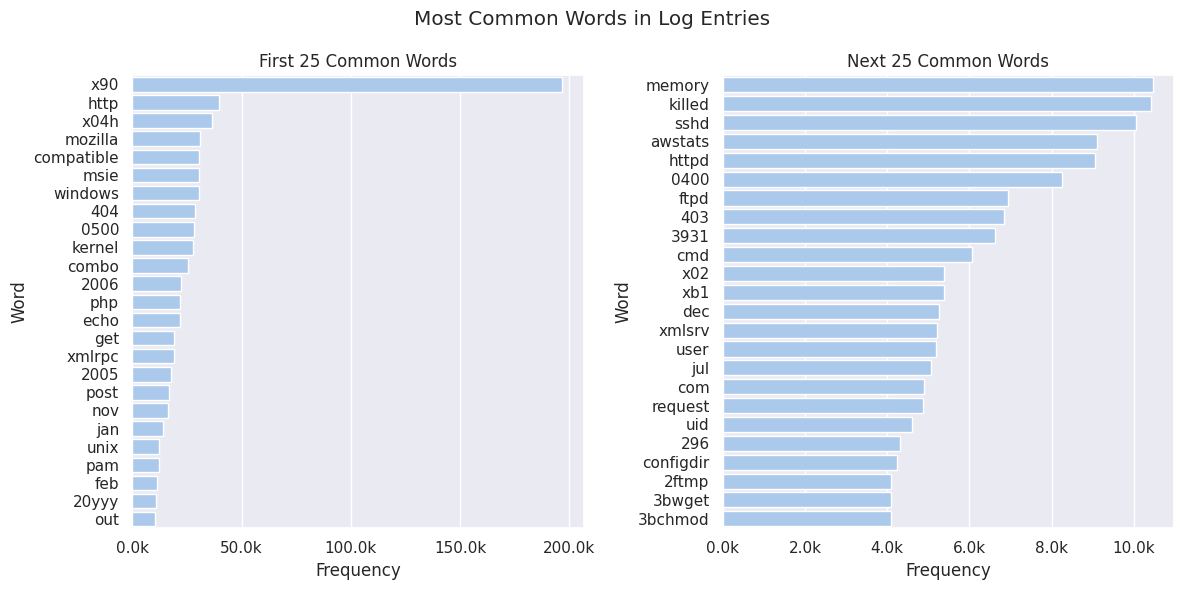

In [63]:
# EDA - word frequecy

def eda_word_freq(p_df: pandas.Series=None)->None:
    df_content = p_df
    # Extracting and visualizing most common log entries (terms)
    from collections import Counter
    all_words = ' '.join(df_content).split()
    # print(f"all_words >>> {all_words}")
    common_words = Counter(all_words).most_common(50)

    # style must be one of white, dark, whitegrid, darkgrid, ticks
    sns.set_theme(palette='pastel')

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    fig.suptitle('Most Common Words in Log Entries')
    # Bar plot for most common words

    t25 = sorted([ list(i)[1] for i in common_words[:25] ], reverse=True)
    print(f"Top 25 word count:\n{t25}")
    x_limit = ((t25[0]/10000)*10000)+10000

    common_words_df = pd.DataFrame(common_words[:25], columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=common_words_df, ax=plt.subplot(1,2,1))
    # plt.title('Plot (1/2)')
    ax[0].set_title('First 25 Common Words')
    div = 50000
    xticks = np.arange(0,x_limit,div)
    xlabels = [f'{x // 1000}k' for x in xticks]
    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels(xlabels)
    # ax[0].set_ylabel('Word')

    t25 = sorted([ list(i)[1] for i in common_words[25:] ], reverse=True)
    print(f"Next top 25 word count:\n{t25}")
    x_limit = ((t25[0]/1000)*1000)+1000

    common_words_df = pd.DataFrame(common_words[26:], columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=common_words_df, ax=plt.subplot(1,2,2))
    # plt.title('Plot (2/2)')
    ax[1].set_title('Next 25 Common Words')
    div = 2000
    xticks = np.arange(0,x_limit,div)
    xlabels = [f'{x // 1000}k' for x in xticks]
    ax[1].set_xticks(xticks)
    ax[1].set_xticklabels(xlabels)

    fig.tight_layout()

eda_word_freq(df['content'])

# Feature Extraction

In [64]:
# feature selection

def word_cnt_sd(p_strings: pandas.Series=None)->int:
    content_length = [ len(str(i).split()) for i in p_strings ]
    content_length
    sd = int(np.std(content_length))+1
    return sd

# def feature_extraction(p_df: pandas.DataFrame=None, p_col_content: str='content', p_col_label: str='log_type'):
p_df = df
p_col_content = 'content'
p_col_label = 'log_type'

word_cnt_sd = word_cnt_sd(p_df[p_col_content])

# tfidf = TfidfVectorizer(max_features=5000)
# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=word_cnt_sd)

X = tfidf.fit_transform(p_df[p_col_content]).toarray()

# column label for log data
le = LabelEncoder()
y = le.fit_transform(df[p_col_label])

In [65]:
# tfidf.vocabulary_
print(len(tfidf.get_feature_names_out()))

159


In [66]:
LOG_TYPES = list(le.classes_)
LOG_TYPES

['httpd_access_log', 'system_messages']

In [67]:
save_obj(p_obj=tfidf, p_filename=TFIDF_FILE)

# Model Training, Testing & Validation

**Key hyperparameters** that can be further tuned or included to improve model performance:
- `clf__n_estimators` (number of trees in the forest)
- `clf__max_depth` (maximum depth of the individual trees; limits the number of nodes in the tree)
- `clf__min_samples_leaf` (minimum samples required to be at a leaf node)
- `max_features` (number of features to consider at each split)



In a Random Forest, each decision tree is trained on a random subset of the features. The `max_features` parameter controls how many features are considered when splitting a node in each tree. This randomness helps to ensure that the trees are not too similar to each other, which is a key aspect of the ensemble method.

In [68]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(49485, 159)
(49485,)
(12372, 159)
(12372,)


In [70]:
# Pipeline with RandomForestClassifier
pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5, 10]
}
# param_grid = {
#     'clf__n_estimators': [5, 10],
#     'clf__max_depth': [5, 10, None],
#     'clf__min_samples_split': [2, 5, 10]
# }
# param_grid = {
#     'clf__n_estimators': [3],
#     'clf__max_depth': [3],
#     'clf__min_samples_split': [5]
# }
# param_grid = {
#     'clf__n_estimators': [2],
#     'clf__max_depth': [2],
#     'clf__min_samples_split': [3]
# }


grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=4)
grid_search.fit(X_train, y_train)

# Best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


# Save Model

In [71]:
save_obj(p_obj=best_model, p_filename=MODEL_FILE)

# Load & Evaluate Model

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7338
           1       1.00      1.00      1.00      5034

    accuracy                           1.00     12372
   macro avg       1.00      1.00      1.00     12372
weighted avg       1.00      1.00      1.00     12372



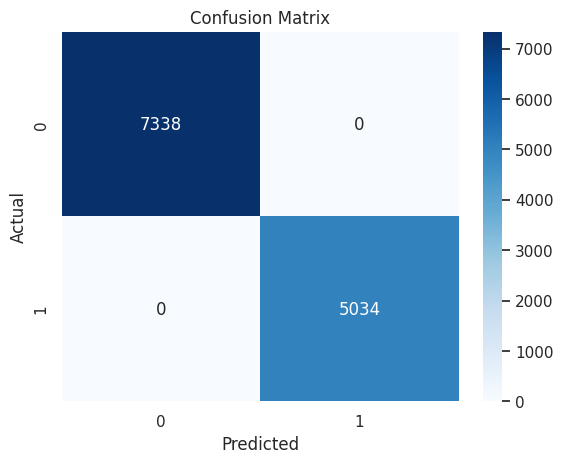

In [72]:
# Predicting on test set
tgt_model = best_model
y_pred = tgt_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Deploy Model for Inference

In [73]:
# tgt_tfidf = load_obj(p_filename=TFIDF_FILE)
# tgt_model = load_obj(p_filename=MODEL_FILE)

In [74]:
# tgt_model = load_obj(p_filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav')
# save_obj(p_obj=tfidf, p_filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav')

model = None
tfidf_vectorizer = None

# Load the trained model from the pickle file
# filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
filename = MODEL_FILE
with open(filename, 'rb') as model_file:
    model = pickle.load(model_file)

# Load the TF-IDF vectorizer
# filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav'
filename = TFIDF_FILE
with open(filename, 'rb') as vectorizer_file:
    tfidf_vectorizer = pickle.load(vectorizer_file)

print(tfidf_vectorizer)
print(model)

TfidfVectorizer(max_features=159)
Pipeline(steps=[('clf', RandomForestClassifier(max_depth=10))])


In [75]:

def classify_log(input_text: list = None):
    tmp = input_text.split('\n')

    line_cnt = len(input_text.split('\n'))-2
    print(f"Total lines received: [{line_cnt}]")
#     print(f"{type(input_text)}\n{tmp}")

    # Preprocess and vectorize the input text
    # input_text_cleaned = clean_str(input_text)
    input_text_cleaned = [ clean_str(i) for i in input_text.split('\n') if len(i)>0 ]
#     print(input_text_cleaned)

    # input_vector = tfidf_vectorizer.transform([input_text_cleaned]).toarray()
    input_vector = tfidf_vectorizer.transform(input_text_cleaned).toarray()

    # Predict the log type
    prediction = model.predict(input_vector)

    # Return the prediction as a readable label
#     print(prediction)
#     return f"Predicted Log Type: {LOG_TYPES[prediction[0]]}"
    result = [ LOG_TYPES[i] for i in prediction ]
    return result

# def classify_log_file(log_file):
#     # Read the text file and concatenate the lines into a single string
#     log_text = log_file.read().decode('utf-8')
#     return classify_log(log_text)

# Define the Gradio interface
iface = gr.Interface(
    fn=classify_log,  # Function to classify text input
    # inputs = gr.interface .inputs.Textbox(lines=10, placeholder="Enter log text here..."),  # Text input
    inputs = gr.Textbox(lines=3, placeholder="Enter log text (line by line) here..."),  # Text input
    outputs="text",  # Text output
    title="Log File Classifier",
    description="Submit 1 log entry per line to classify the type of log."
)

# iface_file_upload = gr.Interface(
#     fn=classify_log_file,  # Function to classify uploaded text file
#     # inputs=gr.inputs.File(type="file"),  # File input
#     inputs = gr.File(type="filepath"),  # File input
#     outputs="text",  # Text output
#     title="Log File Classifier (File Upload)",
#     description="Upload a log file to classify the type of log."
# )

# Combine both interfaces
# iface = gr.TabbedInterface([iface, iface_file_upload], ["Text Input", "File Upload"])
iface = gr.TabbedInterface([iface], ["Text Input"])



# Online Inference Testing

In [76]:
# toggle to deploy
# do not deploy if running to collect artifacts

GR_DEPLOY = False

if GR_DEPLOY:
    # Launch the interface
    iface.launch(debug=True,share=True)


# Offline Inference Testing

In [77]:
s1="""
Jan 25 01:48:27 combo ftpd[929]: connection from 216.19.205.44 (216-19-205-44.getnet.net) at Wed Jan 25 01:48:27 2006
Jan 25 01:48:27 combo ftpd[925]: connection from 216.19.205.44 (216-19-205-44.getnet.net) at Wed Jan 25 01:48:27 2006
Jan 25 01:48:27 combo ftpd[937]: connection from 216.19.205.44 (216-19-205-44.getnet.net) at Wed Jan 25 01:48:27 2006
Jan 25 01:48:27 combo ftpd[933]: connection from 216.19.205.44 (216-19-205-44.getnet.net) at Wed Jan 25 01:48:27 2006
Jan 25 01:48:31 combo ftpd[946]: connection from 216.19.205.44 (216-19-205-44.getnet.net) at Wed Jan 25 01:48:31 2006
Jan 25 01:48:31 combo ftpd[947]: connection from 216.19.205.44 (216-19-205-44.getnet.net) at Wed Jan 25 01:48:31 2006
Jan 25 04:11:13 combo su(pam_unix)[1489]: session opened for user cyrus by (uid=0)
Jan 25 04:11:14 combo su(pam_unix)[1489]: session closed for user cyrus
Jan 25 04:11:15 combo logrotate: ALERT exited abnormally with [1]
Jan 25 04:17:22 combo su(pam_unix)[2749]: session opened for user news by (uid=0)
Jan 25 04:17:23 combo su(pam_unix)[2749]: session closed for user news
Jan 26 04:04:29 combo su(pam_unix)[5074]: session opened for user cyrus by (uid=0)
Jan 26 04:04:29 combo su(pam_unix)[5074]: session closed for user cyrus
"""

s2 = """
[Wed Aug 10 21:17:24 2005] [error] [client 200.67.20.29] Directory index forbidden by rule: /var/www/html/
[Wed Aug 10 22:19:49 2005] [error] [client 12.28.155.101] Directory index forbidden by rule: /var/www/html/
[Wed Aug 10 22:58:16 2005] [error] [client 24.175.102.60] Directory index forbidden by rule: /var/www/html/
[Wed Aug 10 23:10:08 2005] [error] [client 218.84.105.208] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 02:18:29 2005] [error] [client 59.36.212.216] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 02:43:09 2005] [error] [client 62.0.47.69] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 03:40:34 2005] [error] [client 221.8.19.11] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 04:18:35 2005] [error] [client 222.208.123.40] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 05:15:52 2005] [error] [client 68.147.27.208] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 09:29:04 2005] [error] [client 66.21.127.198] Directory index forbidden by rule: /var/www/html/
[Thu Aug 11 10:23:05 2005] [error] [client 202.224.193.213] File does not exist: /var/www/html/phpmyadmin
[Thu Aug 11 10:23:07 2005] [error] [client 202.224.193.213] File does not exist: /var/www/html/phpmyadmin
[Thu Aug 11 10:23:07 2005] [error] [client 202.224.193.213] File does not exist: /var/www/html/phpmyadmin
"""

s3 = """
Sep  1 00:12:20 sekiei gnome-shell[5016]: Window manager warning: Overwriting existing binding of keysym 37 with keysym 37 (keycode 10).
Sep  1 00:12:20 sekiei gnome-shell[5016]: Window manager warning: Overwriting existing binding of keysym 38 with keysym 38 (keycode 11).
Sep  1 00:17:01 sekiei CRON[202112]: (root) CMD (   cd / && run-parts --report /etc/cron.hourly)
Sep  1 00:21:22 sekiei rtkit-daemon[2869]: Supervising 12 threads of 4 processes of 1 users.
Sep  1 00:21:22 sekiei rtkit-daemon[2869]: Supervising 12 threads of 4 processes of 1 users.
Sep  1 00:30:08 sekiei gnome-shell[32933]: [32973:32973:0901/003008.801203:ERROR:shared_image_manager.cc(224)] SharedImageManager::ProduceSkia: Trying to Produce a Skia representation from a non-existent mailbox.
Sep  1 00:30:08 sekiei gnome-shell[32933]: [32973:32973:0901/003008.801982:ERROR:shared_image_manager.cc(224)] SharedImageManager::ProduceSkia: Trying to Produce a Skia representation from a non-existent mailbox.
Sep  1 00:31:44 sekiei rtkit-daemon[2869]: Supervising 12 threads of 4 processes of 1 users.
Sep  1 00:39:39 sekiei rtkit-daemon[2869]: message repeated 3 times: [ Supervising 12 threads of 4 processes of 1 users.]
"""

s4 = """
Sep  1 00:49:08 sekiei gnome-shell[5016]: Can't update stage views actor <unnamed>[<MetaWindowActorX11>:0x5ff5d9806f10] is on because it needs an allocation.
Sep  1 00:49:08 sekiei gnome-shell[5016]: Can't update stage views actor <unnamed>[<MetaSurfaceActorX11>:0x5ff5d97ee320] is on because it needs an allocation.
Sep  1 00:49:10 sekiei rtkit-daemon[2869]: Supervising 12 threads of 4 processes of 1 users.
Sep  1 00:49:10 sekiei rtkit-daemon[2869]: Supervising 12 threads of 4 processes of 1 users.
Sep  1 00:49:11 sekiei gnome-shell[5016]: Can't update stage views actor <unnamed>[<MetaWindowGroup>:0x5ff5d5fa8650] is on because it needs an allocation.
Sep  1 00:49:11 sekiei gnome-shell[5016]: Can't update stage views actor <unnamed>[<MetaWindowActorX11>:0x5ff5d9806b20] is on because it needs an allocation.
127.0.0.1 - - [13/Mar/2022:20:52:43 +0800] "GET / HTTP/1.1" 200 3477 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"
127.0.0.1 - - [13/Mar/2022:20:52:43 +0800] "GET /icons/ubuntu-logo.png HTTP/1.1" 200 3623 "http://127.0.0.1/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"
127.0.0.1 - - [13/Mar/2022:20:52:43 +0800] "GET /favicon.ico HTTP/1.1" 404 487 "http://127.0.0.1/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"
127.0.0.1 - - [13/Mar/2022:20:53:35 +0800] "-" 408 0 "-" "-"
Sep  1 00:17:01 sekiei CRON[202112]: (root) CMD (   cd / && run-parts --report /etc/cron.hourly)
Sep  1 00:47:45 sekiei cups.cups-browsed[3520]: + true
Sep  1 11:50:16 sekiei sbkeysync[2146]:     3608edbaf5ad0f41a414a1777abf2faf5e670334675ec3995e6935829e0caad2
Sep  1 11:50:16 sekiei sbkeysync[2146]:      from /usr/share/secureboot/updates/dbx/dbxupdate_x64.bin
"""

s = [s1, s2, s3, s4]
_ = [ print(classify_log(i)) for i in s ]



Total lines received: [13]
['system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages']
Total lines received: [13]
['system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'httpd_access_log', 'httpd_access_log', 'httpd_access_log']
Total lines received: [9]
['system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages']
Total lines received: [14]
['system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'system_messages', 'httpd_access_log', 'httpd_access_log', 'httpd_access_log', 'system_messages', 'system_messages', 'system_m